In [1]:
# Import packages
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from matplotlib.pylab import rcParams
import itertools
import numpy as np
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from fbprophet import Prophet


# Preferred settings
warnings.simplefilter("ignore")


<ipython-input-1-057088e0c8b3>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
# Import saved data
df_TS = pd.read_csv('Data/df_TS.csv')

# Set date column to datetime object
df_TS['Date'] = pd.to_datetime(df_TS['Date'])

# Set date column as index
df_TS.set_index('Date', inplace=True)

# Prepare Data

In [3]:
# Only use pre-COVID data for time series modeling
df_TS_preCOV = df_TS.loc[:'2020-3-13']


In [4]:
# Create df of only Manhattan data, remove all columns other than accident counts 
df_prophet = df_TS_preCOV.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Qns', 'Accidents_Bkln', 'Accidents_SI',
                               'Accidents_Total','Season','Day of Week', 'Weekend','Holiday'])

# Rename columns to [ds,y] per fb prophet specifications
df_prophet['ds'] = df_prophet.index
df_prophet.rename(columns={'Accidents_Man': 'y'},inplace=True)


In [5]:
df_prophet.head()

y         ds
Date                        
2012-07-01  122.0 2012-07-01
2012-07-02  122.0 2012-07-02
2012-07-03  155.0 2012-07-03
2012-07-04   71.0 2012-07-04
2012-07-05  114.0 2012-07-05

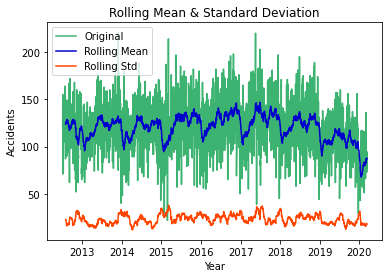

Test Statistic                   -4.079844
p-value                           0.001046
#Lags Used                       27.000000
Number of Observations Used    2783.000000
dtype: float64

In [6]:
# Visualize data, including 30-day rolling mean and standard deviation

roll_mean = df_prophet['y'].rolling(window=30, center=False).mean()
roll_std = df_prophet['y'].rolling(window=30, center=False).std()

plt.plot(df_prophet['y'],color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std, color='orangered', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(df_prophet['y'][1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Based on the above visualization and Dickey-Fuller p-value, we see that this data is stationary. We will therefore not perform differencing, a log transformation, or any other transformation on the data before fitting a model.

# Facebook Prophet Modeling

## Train-Test Split

In [7]:
# Train-test split
# 2019-06-06 will be the split point for our train and test sets, which is a 90%/10% split

X = df_prophet.index
y = df_prophet['y']

train = df_prophet.loc[:'2019-06-06']
test = df_prophet.loc['2019-06-07':]

X_train, X_test = train.index , test.index
y_train, y_test = train['y'] , test['y']

## Fit Model and Generate Predictions

In [8]:
# Fit model to data
model = Prophet(interval_width=0.95)
model.fit(train)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
# Make predictions 1120 days into the future--ie until 6/30/22
# This way we will have a full year of model-predicted data after starting on 7/1/21
# Create future dates
future_dates = model.make_future_dataframe(periods=1120, freq='D')

# Generate predictions
forecast = model.predict(future_dates)
forecast.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
3647 2022-06-26  82.121174   24.082332  100.984404    71.694399    92.680536   
3648 2022-06-27  82.094111   43.168120  117.132661    71.656324    92.664954   
3649 2022-06-28  82.067048   55.729086  128.092731    71.618250    92.649372   
3650 2022-06-29  82.039986   52.903276  129.457127    71.580175    92.633789   
3651 2022-06-30  82.012923   59.803895  136.007285    71.542101    92.618207   

      additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
3647      -19.272385            -19.272385            -19.272385 -26.023237   
3648       -2.239661             -2.239661             -2.239661  -7.965165   
3649        9.885891              9.885891              9.885891   5.197276   
3650        9.526116              9.526116              9.526116   5.864701   
3651       13.597122             13.597122             13.597122  10.932031   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
3647    -26.023237    -26.023237  6.750852      6.750852      6.750852   
3648     -7.965165     -7.965165  5.725504      5.725504      5.725504   
3649      5.197276      5.197276  4.688615      4.688615      4.688615   
3650      5.864701      5.864701  3.661415      3.661415      3.661415   
3651     10.932031     10.932031  2.665091      2.665091      2.665091   

      multiplicative_terms  multiplicative_terms_lower  \
3647                   0.0                         0.0   
3648                   0.0                         0.0   
3649                   0.0                         0.0   
3650                   0.0                         0.0   
3651                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
3647                         0.0  62.848789  
3648                         0.0  79.854450  
3649                         0.0  91.952939  
3650                         0.0  91.566101  
3651                         0.0  95.610045

## Visualize Model

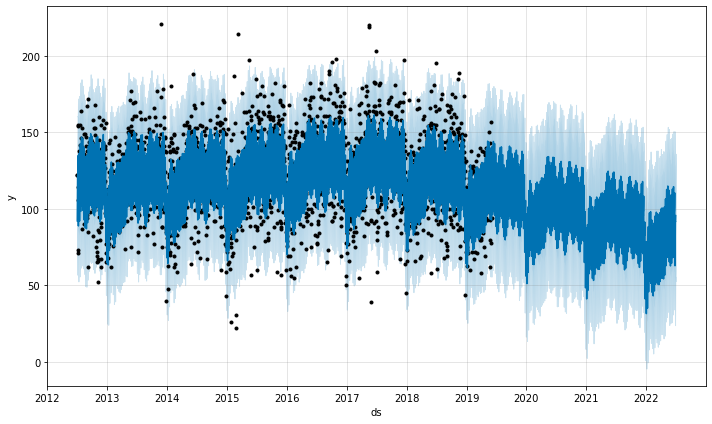

In [10]:
# Subset useful columns from forecast
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Plot forecast
model.plot(forecast,uncertainty=True)
plt.show()

## Assess Model

In [12]:
# Assess model using RMSE to compare to our working SARIMAX model
# Create RMSE function
def RMSE(pred):
    return np.sqrt(((pred-y_test)**2).mean())

# Define test predictions
test_preds = forecast.set_index('ds').loc['2019-06-07':'2020-03-13']

# Define fb prophet RMSE
fb_RMSE = RMSE(test_preds['yhat'])

# Compare to SARIMAX RMSE to determine the better model
print('FB Prophet: RMSE: ', fb_RMSE, ', Adjusted RMSE: ',
      fb_RMSE/(df_prophet.loc[:'2020-03-13']['y'].max()-df_prophet.loc[:'2020-03-13']['y'].min()))
print('SARIMAX: RMSE: ', 11.093035021610836, ', Adjusted RMSE: ', 0.10579188712707882)


FB Prophet: RMSE:  19.045171667993195 , Adjusted RMSE:  0.09570438024117184
SARIMAX: RMSE:  11.093035021610836 , Adjusted RMSE:  0.10579188712707882


Based on the above adjusted RMSEs, we see that our FB Prophet model performs 9% better than our SARIMAX model. We will therefore consider this our best model.

## Adjust Predictions to Account for COVID

The above represents accident frequency predictions assuming the COVID-19 pandemic had not occured. Now we will adjust our predictions in the same way we did for our ARIMA model.

In [13]:
# Create Manhattan dataframe with all known data, not only pre-COVID
df_man_total = df_TS.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Bkln', 'Accidents_Qns', 'Accidents_SI',
                               'Accidents_Total'])

# Create line connecting end of known data to predicted July data

# Begin model-based predictions on 7/1/21, diminish by 25%.
TS_pred_cov = forecast.set_index('ds').loc['2021-07-01':'2022-06-30']['yhat'] * 0.75

# Since there is more varibility in this model than there was in the ARIMA one and there is weekly seasonality,
# make 6/30/21 values the same as 7/7/2021 since they are the same day of the week
june_30 = TS_pred_cov.loc['2021-07-07']

# Create df for connection data
connection = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-06-30'))
connection['Date'] = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-06-30'))

# Find how much the accident count will rise each day
# There are 151 days between 1/29/21 and 6/30/21
daily_interval=(june_30 - df_man_total['Accidents_Man']['2021-01-29'])/151

# Add daily interval to each date in connection df
connection_forecasts = []
i = df_man_total['Accidents_Man']['2021-01-29']
for num in range(0,151):
    i+=daily_interval
    connection_forecasts.append(i)
    
# Add 6/30/21 to forecases
connection_forecasts.append(june_30)
    
# Add list of forecasts to connection df
connection['Forecast'] = connection_forecasts

# Make date index of connection df
connection.set_index('Date', inplace=True)
connection.drop(columns=0,inplace=True)

#Observe connection df
connection

Forecast
Date                 
2021-01-30  28.289484
2021-01-31  28.578968
2021-02-01  28.868452
2021-02-02  29.157936
2021-02-03  29.447421
...               ...
2021-06-26  70.843649
2021-06-27  71.133133
2021-06-28  71.422617
2021-06-29  71.712101
2021-06-30  71.712101

[152 rows x 1 columns]

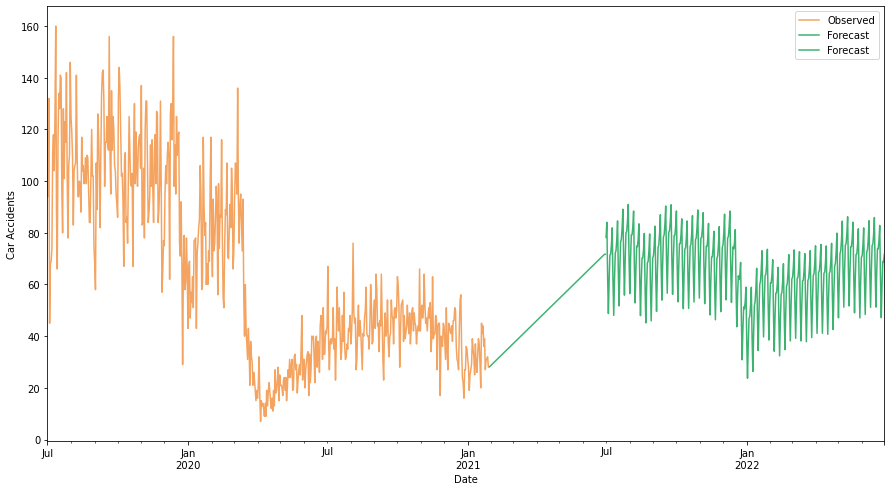

In [14]:
fix,ax = plt.subplots(figsize=(15,8))

# Plot known data
ax = df_man_total['Accidents_Man']['2019-07-01':].plot(label='Observed', color='sandybrown')

# Plot predicted data based on model, starting 7/1/20, 75% of model prediction
TS_pred_cov.plot(ax=ax, label='Forecast', color='mediumseagreen')

# Plot linear connection
connection.plot(ax=ax, color='mediumseagreen')

ax.set_xlabel('Date')
ax.set_ylabel('Car Accidents')

plt.legend()
plt.show()

Note we specifically did not include a confidence interval because this would be misleading given that it would not account for the uncertainty associated with the way we produced our predictions in regards to COVID-affected data.

# Export Data

In [15]:
# Create one df combining known and predicted accident frequencies
# Round forecasts to integers 
data_preds_man = pd.concat([df_man_total['Accidents_Man'],round(connection['Forecast']),round(TS_pred_cov)])


In [16]:
# Export data
data_preds_man.to_csv('Data/data_preds_man.csv')